# Stochastic Models in Finance: TP4
By: 
- Adonis JAMAL
- Ayoub EL KBADI
- Fotios KAPOTOS

In [1]:
import numpy as np
from scipy.stats import norm
from scipy.sparse import diags
from scipy.linalg import solve_banded
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [2]:
# Model values
S0 = 100    # initial stock price
K = 100     # strike price
T = 1.0     # time to maturity in years
r = 0.05    # risk-free rate
sigma = 0.2 # volatility
d = 12      # number of observations
N = 100     # number of spatial steps
M = 100     # number of time steps

## TP Question IV.1

1. Prix EDP du call européen et comparaison avec la formule de Black-Scholes

In [3]:
def black_scholes_call_price(S0, K, T, r, sigma):
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T) + 1e-10)
    d2 = d1 - sigma * np.sqrt(T)
    return S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)


def pde_price_implicit(S0, K, T, r, sigma, M, N, L_factor=4):
    """
    Solves the Black-Scholes PDE using the implicit Euler method.

    Args:
        M (int): number of time steps
        N (int): number of spatial steps
        L_factor (float, optional): Factor to extend the grid. Defaults to 4.
    """
    dt = T / M

    # Spatial grid
    y_min = np.log(K) - L_factor * sigma * np.sqrt(T)
    y_max = np.log(K) + L_factor * sigma * np.sqrt(T)
    h = (y_max - y_min) / N
    y_grid = np.linspace(y_min, y_max, N + 1)
    S_grid = np.exp(y_grid)

    # Initial condition
    U = np.maximum(S_grid - K, 0)

    # PDE coefficients to construct tridiagonal matrix
    alpha = dt * (- sigma**2 / (2 * h**2) + (r - 0.5 * sigma**2) / (2 * h))
    beta = 1 + dt * (sigma**2 / h**2 + r)
    gamma = dt * (- sigma**2 / (2 * h**2) - (r - 0.5 * sigma**2) / (2 * h))

    # Construct the matrix for interior points i=1 to N-1
    d_main = np.full(N - 1, beta)
    d_lower = np.full(N - 1, alpha)
    d_upper = np.full(N - 1, gamma)

    # We use this format for the imported solve_banded function
    ab = np.zeros((3, N - 1))
    ab[0, 1:] = d_upper[:-1]  # upper diagonal
    ab[1, :] = d_main         # main diagonal
    ab[2, :-1] = d_lower[1:]  # lower diagonal

    # Time stepping
    for j in range(M):
        U_prev = U[1:N]

        # Limit conditions
        # y -> -inf, Call -> 0
        bc_lower = 0
        # y -> +inf, Call -> S - K * exp(-r * tau)
        tau_next = (j + 1) * dt
        bc_upper = np.exp(y_grid[N]) - K * np.exp(-r * tau_next)

        # Adjust the vector for boundary conditions
        b = U_prev.copy()
        b[0] -= alpha * bc_lower
        b[-1] -= gamma * bc_upper

        # Solve and update the solution
        U_inner = solve_banded((1, 1), ab, b)
        U[1:N] = U_inner
        U[0] = bc_lower
        U[N] = bc_upper
    
    return S_grid, U

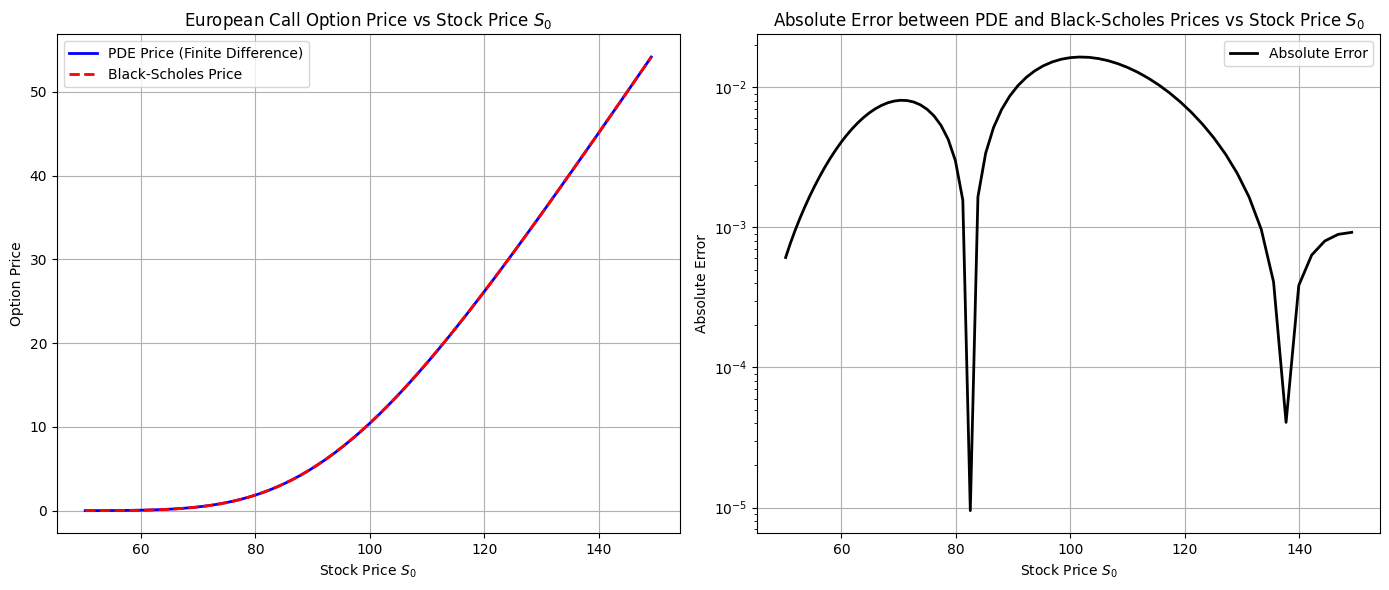

In [4]:
s_pde, price_pde = pde_price_implicit(S0, K, T, r, sigma, M, N)
price_bs = black_scholes_call_price(s_pde, K, T, r, sigma)

mask = (s_pde >= 0.5 * K) & (s_pde <= 1.5 * K)

# Plot
plt.figure(figsize=(14, 6))

# PDE Price vs S0
plt.subplot(1, 2, 1)
plt.plot(s_pde[mask], price_pde[mask], 'b-', label='PDE Price (Finite Difference)', linewidth=2)
plt.plot(s_pde[mask], price_bs[mask], 'r--', label='Black-Scholes Price', linewidth=2)
plt.title('European Call Option Price vs Stock Price $S_0$')
plt.xlabel('Stock Price $S_0$')
plt.ylabel('Option Price')
plt.legend()
plt.grid(True)

# Error plot
plt.subplot(1, 2, 2)
error = np.abs(price_pde - price_bs)
plt.plot(s_pde[mask], error[mask], 'k-', label='Absolute Error', linewidth=2)
plt.title('Absolute Error between PDE and Black-Scholes Prices vs Stock Price $S_0$')
plt.xlabel('Stock Price $S_0$')
plt.ylabel('Absolute Error')
plt.legend()
plt.grid(True)
plt.yscale('log')

plt.tight_layout()
plt.show()

On observe que le prix obtenu par la méthode des différences finies implicites est très proche de celui obtenu par la formule de Black-Scholes, avec une erreur négligeable.

Cette erreur est plus importante autour du strike ($S_0 \approx K=100$), ce qui est attendu car la condition initiale (payoff $(S - K)_+$) n'est pas dérivable en ce point $K$, ce qui réduit la précision de la méthode numérique.

2. Erreur en norme infinie du vecteur de prix EDP en fonction de $N$

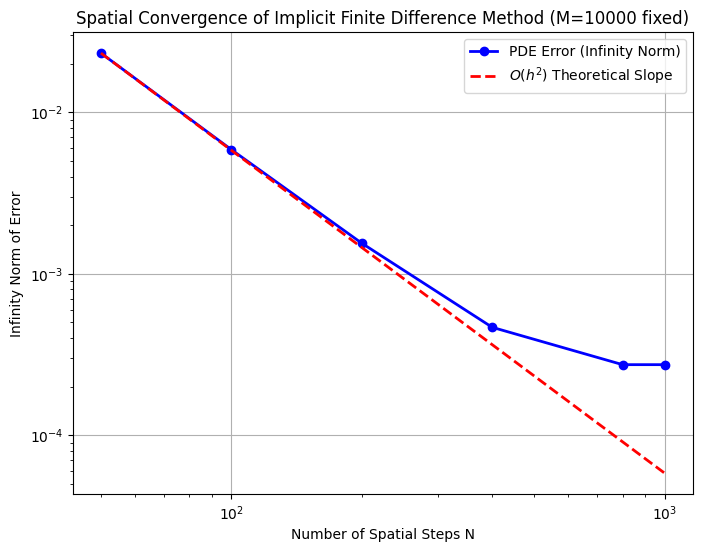

Estimated spatial convergence rate: -1.51


In [5]:
# Fix large M and vary N to study spatial error
M_fixed = 10**4
N_values = [50, 100, 200, 400, 800, 1000]

errors_spatial = []
h_values = []

for N in N_values:
    # Solve PDE and compute Black-Scholes price
    s_pde, price_pde = pde_price_implicit(S0, K, T, r, sigma, M_fixed, N)
    price_bs = black_scholes_call_price(s_pde, K, T, r, sigma)
    
    # Compute infinity norm of the error
    error_inf = np.max(np.abs(price_pde - price_bs))
    errors_spatial.append(error_inf)

# Plot
plt.figure(figsize=(8, 6))

# Log-Log plot of spatial error
plt.loglog(N_values, errors_spatial, 'bo-', label='PDE Error (Infinity Norm)', linewidth=2)

# Reference line for O(h^2)
ref_order_2 = [errors_spatial[0] * (N_values[0] / N)**2 for N in N_values]
plt.loglog(N_values, ref_order_2, 'r--', label='$O(h^2)$ Theoretical Slope', linewidth=2)

plt.title(f'Spatial Convergence of Implicit Finite Difference Method (M={M_fixed} fixed)')
plt.xlabel('Number of Spatial Steps N')
plt.ylabel('Infinity Norm of Error')
plt.legend()
plt.grid(True)
plt.show()

# Compute slope
slope, intercept = np.polyfit(np.log(N_values), np.log(errors_spatial), 1)
print(f"Estimated spatial convergence rate: {slope:.2f}")

Théoriquement, la méthode des différences finies implicites pour l'équation de Black-Scholes est d'ordre 2 en espace, donc on s'attend à une erreur en norme infinie qui diminue comme $O(1/N^2)$ lorsque $N$ augmente. Sur le graphique log-log ci-dessus, cela se traduit par une droite de pente -2.

$M$ est fixé à 10000 pour minimiser l'erreur temporelle et se concentrer sur l'erreur spatiale. On observe que, quand $N$ reste petit relativement à $M$, les points expérimentaux suivent une tendance linéaire avec une pente proche de -2, confirmant l'ordre 2 en espace. Cependant, plus $N$ augmente, la pente augmente, indiquant que l'erreur ne diminue plus comme $O(1/N^2)$. Cela est dû au fait que l'erreur temporelle devient dominante tandis que l'erreur spatiale diminue.

L'erreur totale plafonne donc sur la valeur de l'erreur temporelle, expliquant la saturation observée pour les grandes valeurs de $N$.

Par ailleurs, le payoff $(S - K)_+$ n'étant pas dérivable en $K$, la précision de la méthode est réduite, ce qui peut aussi contribuer à la perturbation de la convergence.

3. Erreur en norme infinie du vecteur de prix EDP en fonction de $M$

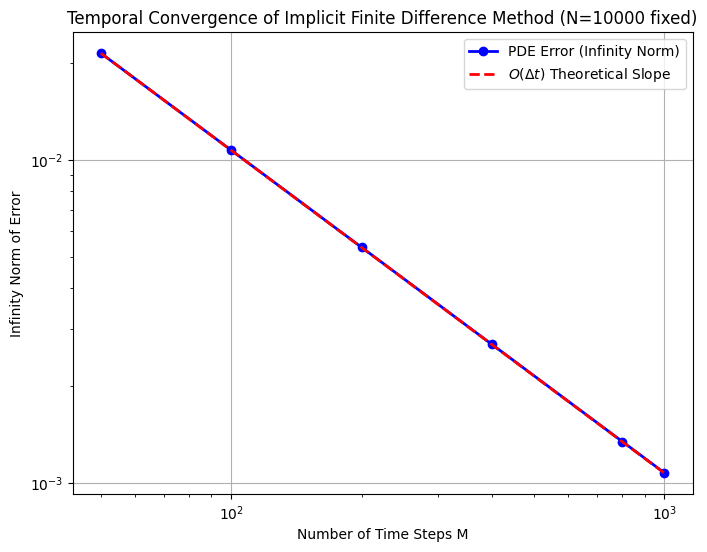

Estimated temporal convergence rate: -1.00


In [6]:
N_fixed = 10**4
M_values = [50, 100, 200, 400, 800, 1000]

errors_temporal = []
dt_values = []

for M in M_values:
    # Solve PDE and compute Black-Scholes price
    s_pde, price_pde = pde_price_implicit(S0, K, T, r, sigma, M, N_fixed)
    price_bs = black_scholes_call_price(s_pde, K, T, r, sigma)
    
    # Compute infinity norm of the error
    error_inf = np.max(np.abs(price_pde - price_bs))
    errors_temporal.append(error_inf)
    dt_values.append(T / M)

# Plot
plt.figure(figsize=(8, 6))

# Log-Log plot of temporal error
plt.loglog(M_values, errors_temporal, 'bo-', label='PDE Error (Infinity Norm)', linewidth=2)

# Reference line for O(dt)
ref_order_1 = [errors_temporal[0] * (M_values[0] / M) for M in M_values]
plt.loglog(M_values, ref_order_1, 'r--', label='$O(\Delta t)$ Theoretical Slope', linewidth=2)

plt.title(f'Temporal Convergence of Implicit Finite Difference Method (N={N_fixed} fixed)')
plt.xlabel('Number of Time Steps M')
plt.ylabel('Infinity Norm of Error')
plt.legend()
plt.grid(True)
plt.show()

# Compute slope
slope, intercept = np.polyfit(np.log(M_values), np.log(errors_temporal), 1)
print(f"Estimated temporal convergence rate: {slope:.2f}")


Cette fois, $N$ est fixé à 10000 pour minimiser l'erreur spatiale et se concentrer sur l'erreur temporelle. On observe que les points expérimentaux suivent une tendance linéaire avec une pente extrêmement proche de -1, confirmant que la méthode est d'ordre 1 en temps.

Le payoff $(S - K)_+$ pose moins de problème pour la convergence temporelle que spatiale.

4. Erreur ponctuelle $|u_i^j - u(j\Delta T, y_i)|$ en fonction de $t = T - j \Delta T \in [0, T]$ et $S = e^{y_i} \in [e^{-L}, e^{L}]$

In [7]:
# We modify the pde_price_implicit function to return the full solution grid
def pde_price_implicit_full(S0, K, T, r, sigma, M, N, L_factor=4):
    dt = T / M

    # Spatial grid
    y_min = np.log(K) - L_factor * sigma * np.sqrt(T)
    y_max = np.log(K) + L_factor * sigma * np.sqrt(T)
    h = (y_max - y_min) / N
    y_grid = np.linspace(y_min, y_max, N + 1)
    S_grid = np.exp(y_grid)

    # History array
    U_history = np.zeros((M + 1, N + 1))

    # Initial condition
    U = np.maximum(S_grid - K, 0)
    U_history[0, :] = U.copy()

    # PDE coefficients to construct tridiagonal matrix
    alpha = dt * (- sigma**2 / (2 * h**2) + (r - 0.5 * sigma**2) / (2 * h))
    beta = 1 + dt * (sigma**2 / h**2 + r)
    gamma = dt * (- sigma**2 / (2 * h**2) - (r - 0.5 * sigma**2) / (2 * h))

    # Construct the matrix for interior points i=1 to N-1
    d_main = np.full(N - 1, beta)
    d_lower = np.full(N - 1, alpha)
    d_upper = np.full(N - 1, gamma)

    # We use this format for the imported solve_banded function
    ab = np.zeros((3, N - 1))
    ab[0, 1:] = d_upper[:-1]  # upper diagonal
    ab[1, :] = d_main         # main diagonal
    ab[2, :-1] = d_lower[1:]  # lower diagonal

    # Time stepping
    for j in range(M):
        U_prev = U[1:N]
        tau_next = (j + 1) * dt

        bc_lower = 0
        bc_upper = np.exp(y_grid[N]) - K * np.exp(-r * tau_next)

        b = U_prev.copy()
        b[0] -= alpha * bc_lower
        b[-1] -= gamma * bc_upper

        U_inner = solve_banded((1, 1), ab, b)
        U[1:N] = U_inner
        U[0] = bc_lower
        U[N] = bc_upper

        U_history[j + 1, :] = U.copy()

    tau_vals = np.linspace(0, T, M + 1)
    t_vals = T - tau_vals
    return S_grid, t_vals, U_history

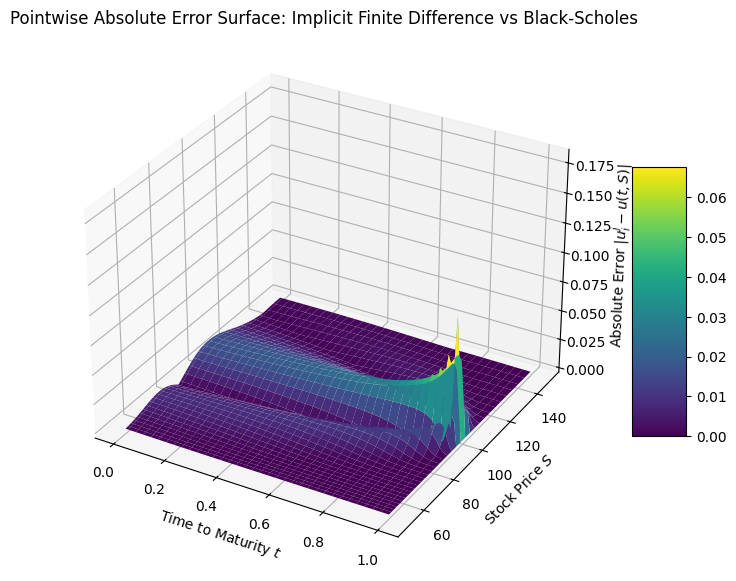

In [8]:
M_plot = 100
N_plot = 100

# Generate full solution surface
S_vec, t_vec, U_surf = pde_price_implicit_full(S0, K, T, r, sigma, M_plot, N_plot)

# 
tau_vec = T - t_vec
S_mesh, Tau_mesh = np.meshgrid(S_vec, tau_vec)

exact_surface = np.zeros_like(U_surf)

for i, tau in enumerate(tau_vec):
    if tau == 0:
        exact_surface[i, :] = np.maximum(S_vec - K, 0)
    else:
        exact_surface[i, :] = black_scholes_call_price(S_vec, K, tau, r, sigma)

error_surface = np.abs(U_surf - exact_surface)

# 3D Surface Error Plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

mask = (S_vec > 50) & (S_vec < 150)
S_plot = S_mesh[:, mask]
T_plot = T - Tau_mesh[:, mask]
Error_plot = error_surface[:, mask]

surf = ax.plot_surface(T_plot, S_plot, Error_plot, cmap=cm.viridis)
ax.set_xlabel('Time to Maturity $t$')
ax.set_ylabel('Stock Price $S$')
ax.set_zlabel('Absolute Error $|u_i^j - u(t, S)|$')
ax.set_title('Pointwise Absolute Error Surface: Implicit Finite Difference vs Black-Scholes')

fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()


Le graphique ci-dessus montre l'erreur ponctuelle entre la solution numérique $u_i^j$ obtenue par la méthode des différences finies implicites et la solution analytique $u(t, S)$ donnée par la formule de Black-Scholes, en fonction du temps $t = T - j \Delta T$ et du prix de l'actif sous-jacent $S = e^{y_i}$.

On remarque que le pic d'erreur se situe à $t=1$ (Maturité) et autour du strike $S=K=100$. Cela est cohérent avec le fait que la condition initiale (payoff $(S - K)_+$) n'est pas dérivable en $K$, ce qui engendre une plus grande erreur numérique près de ce point. 

De plus, l'erreur diminue à mesure que l'on s'éloigne de la maturité, car la solution devient plus lisse. En effet, l'EDP de Black-Scholesest une équation parabolique (diffusion), et la diffusion tend à lisser les irrégularités au fil du temps. 

## TP Question IV.2 (facultatif)

Pour cette partie, nous nous baserons sur le papier: "Solving Nonlinear Partial Differential Equations via Deep Galerkin Method" de Xinjun Ji, 2022, Journal of Physics.

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


1. Deep Galerkin pour l'EDP de Black-Scholes

In [10]:
class DGM(nn.Module):
    def __init__(self, num_neurons=50):
        super(DGM, self).__init__()
        self.layer1 = nn.Linear(2, num_neurons)
        self.layer2 = nn.Linear(num_neurons, num_neurons)
        self.layer3 = nn.Linear(num_neurons, num_neurons)
        self.output = nn.Linear(num_neurons, 1)
        self.activation = nn.Tanh() # Tanh to guarantee second-order differentiability

    def forward(self, t, x):
        x_norm = x / K  # Normalize S by K to improve training stability

        inputs = torch.cat([t, x_norm], dim=1)
        x = self.activation(self.layer1(inputs))
        x = self.activation(self.layer2(x))
        x = self.activation(self.layer3(x))
        u = self.output(x)
        return u
    
def compute_loss(model, batch_size, S_min=0.0, S_max=30.0):
    """
    Implements loss function J(f) based on the Xinjun Ji paper.
    """
    # Domain interior
    t_interior = torch.rand(batch_size, 1, device=device, requires_grad=True) * T
    S_interior = torch.rand(batch_size, 1, device=device, requires_grad=True) * (S_max - S_min) + S_min

    u = model(t_interior, S_interior)

    # Compute derivatives
    grads = torch.autograd.grad(u, [t_interior, S_interior], torch.ones_like(u), create_graph=True, retain_graph=True)
    u_t = grads[0]
    u_x = grads[1]
    u_xx = torch.autograd.grad(u_x, S_interior, torch.ones_like(u_x), create_graph=True, retain_graph=True)[0]

    # PDE residual
    pde_residual = u_t + r * S_interior * u_x + 0.5 * sigma**2 * S_interior**2 * u_xx - r * u
    loss_interior = torch.mean(pde_residual**2)

    # Terminal condition
    t_terminal = T * torch.ones(batch_size, 1, device=device)
    S_terminal = torch.rand(batch_size, 1, device=device) * (S_max - S_min) + S_min
    u_terminal = model(t_terminal, S_terminal)
    payoff = torch.relu(S_terminal - K)
    loss_terminal = torch.mean((u_terminal - payoff)**2)

    # Boundary condition
    # The paper uses Dirichlet conditions
    # Boundary S = 0 -> Call = 0
    t_b1 = torch.rand(batch_size, 1, device=device) * T
    S_b1 = torch.zeros(batch_size, 1, device=device)
    u_b1 = model(t_b1, S_b1)
    loss_b1 = torch.mean(u_b1**2)

    # Boundary S = S_max -> Call = S - K * exp(-r * (T - t))
    t_b2 = torch.rand(batch_size, 1, device=device) * T
    S_b2 = S_max * torch.ones(batch_size, 1, device=device)
    u_b2 = model(t_b2, S_b2)
    val_b2 = S_b2 - K * torch.exp(-r * (T - t_b2))
    loss_b2 = torch.mean((u_b2 - val_b2)**2)

    loss_boundary = loss_b1 + loss_b2

    return loss_interior + loss_terminal + loss_boundary

In [11]:
# Domaine spatial S
S_min, S_max = 0.0, 300.0

In [12]:
# Training
model = DGM(num_neurons=50).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 10000
batch_size = 1000

loss_history = []
print(f"Training Deep Galerkin Method model for {num_epochs} epochs...")
for epoch in range(num_epochs):
    optimizer.zero_grad()
    loss = compute_loss(model, batch_size, S_min, S_max)
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())

    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

Training Deep Galerkin Method model for 10000 epochs...
Epoch 0, Loss: 50658.710938
Epoch 500, Loss: 35012.171875
Epoch 1000, Loss: 25599.203125
Epoch 1500, Loss: 18397.753906
Epoch 2000, Loss: 13207.593750
Epoch 2500, Loss: 8726.947266
Epoch 3000, Loss: 5719.841309
Epoch 3500, Loss: 3507.892578
Epoch 4000, Loss: 2028.410400
Epoch 4500, Loss: 1078.784424
Epoch 5000, Loss: 574.229004
Epoch 5500, Loss: 262.599243
Epoch 6000, Loss: 114.136108
Epoch 6500, Loss: 36.442215
Epoch 7000, Loss: 9.185454
Epoch 7500, Loss: 3.660009
Epoch 8000, Loss: 1.227013
Epoch 8500, Loss: 1.047219
Epoch 9000, Loss: 0.344383
Epoch 9500, Loss: 0.169698


In [13]:
model.eval()
S_test = np.linspace(S_min, S_max, 300)
t_test = np.zeros_like(S_test)

S_tensor = torch.FloatTensor(S_test.reshape(-1, 1)).to(device)
t_tensor = torch.FloatTensor(t_test.reshape(-1, 1)).to(device)

with torch.no_grad():
    P_dgm = model(t_tensor, S_tensor).cpu().numpy().flatten()

P_exact = black_scholes_call_price(S_test, K, T, r, sigma)

C:\Users\adoni\AppData\Local\Temp\ipykernel_28192\3053018995.py:2: RuntimeWarning: divide by zero encountered in log
  d1 = (np.log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T) + 1e-10)


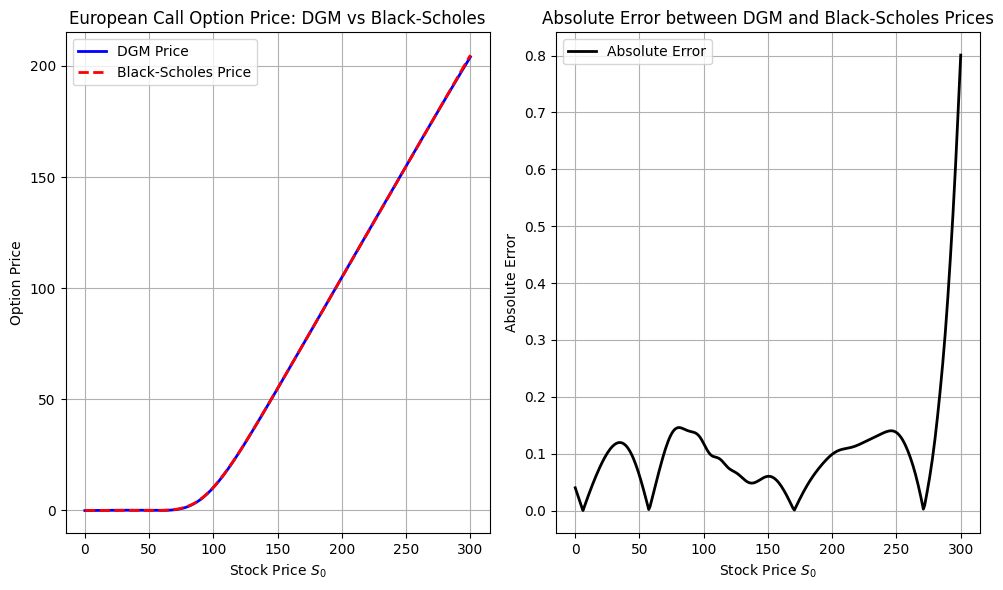

In [14]:
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.plot(S_test, P_dgm, 'b-', label='DGM Price', linewidth=2)
plt.plot(S_test, P_exact, 'r--', label='Black-Scholes Price', linewidth=2)
plt.title('European Call Option Price: DGM vs Black-Scholes')
plt.xlabel('Stock Price $S_0$')
plt.ylabel('Option Price')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(S_test, np.abs(P_dgm - P_exact), 'k-', label='Absolute Error', linewidth=2)
plt.title('Absolute Error between DGM and Black-Scholes Prices')
plt.xlabel('Stock Price $S_0$')
plt.ylabel('Absolute Error')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

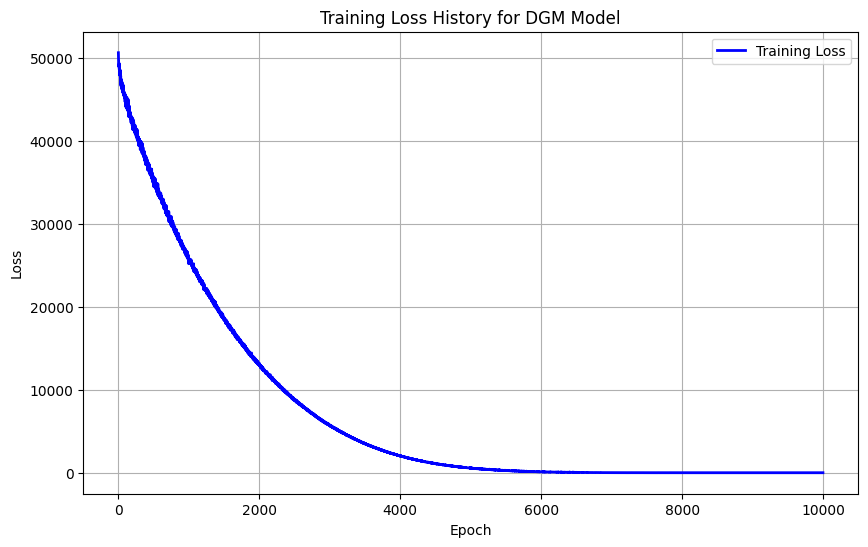

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(loss_history, 'b-', label='Training Loss', linewidth=2)
plt.title('Training Loss History for DGM Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
np.mean(loss_history[-500:])  # Average loss over last 500 epochs

np.float64(0.19504028292000294)

On observe que la solution approchée par le modèle DGM se superpose presque parfaitement à la solution analytique donnée par la formule de Black-Scholes.

Le réseau a bien appris la forme du call européen, y compris la convexité autour du strike.

L'erreur entre la solution DGM et la solution analytique est très faible, de l'ordre de 1e-1 autour du strike, mais augmente quand le prix de l'actif s'éloigne du strike. Par ailleurs, on note que l'on observe une augmentation assez brusque de l'erreur autour du strike, ce qui peut être dû au fait que la dérivée seconde est la plus forte dans cette région, rendant l'approximation plus difficile pour le réseau de neurones par rapport aux régions linéaires.

La courbe de perte diminue rapidement au début de l'entraînement, puis commence à se stabiliser, indiquant que le modèle converge vers une solution satisfaisante.

2. Prix en norme infinie du vecteur de prix EDP

Infinity norm of the error between DGM and Black-Scholes: 0.800764


C:\Users\adoni\AppData\Local\Temp\ipykernel_28192\3053018995.py:2: RuntimeWarning: divide by zero encountered in log
  d1 = (np.log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T) + 1e-10)


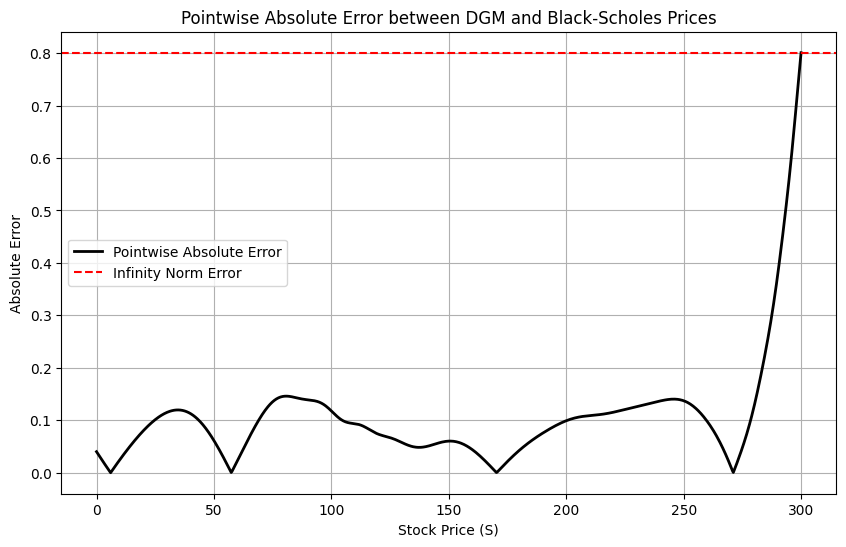

In [17]:
S_fine = np.linspace(S_min, S_max, 1000)
t_fine = np.zeros_like(S_fine)

# Prediction
model.eval()
with torch.no_grad():
    P_dgm_fine = model(torch.FloatTensor(t_fine.reshape(-1, 1)).to(device), 
                       torch.FloatTensor(S_fine.reshape(-1, 1)).to(device)).cpu().numpy().flatten()
    
P_exact_fine = black_scholes_call_price(S_fine, K, T, r, sigma)

# Pointwise error
pointwise_error = np.abs(P_dgm_fine - P_exact_fine)

# Infinity norm
infinity_norm_error = np.max(pointwise_error)

print(f"Infinity norm of the error between DGM and Black-Scholes: {infinity_norm_error:.6f}")

# Plot
plt.figure(figsize=(10, 6))
plt.plot(S_fine, pointwise_error, 'k-', label='Pointwise Absolute Error', linewidth=2)
plt.axhline(y=infinity_norm_error, color='r', linestyle='--', label='Infinity Norm Error')
plt.xlabel('Stock Price (S)')
plt.ylabel('Absolute Error')
plt.title('Pointwise Absolute Error between DGM and Black-Scholes Prices')
plt.legend()
plt.grid(True)
plt.show()

On observe un pic d'erreur autour du strike, ce qui est cohérent avec la non-différentiabilité du payoff en ce point. Cependant, l'erreur globale reste relativement faible, indiquant que le modèle DGM parvient à capturer la dynamique de l'EDP de Black-Scholes de manière satisfaisante malgré cette difficulté.

Cependant, par rapport à la méthode des différences finies implicites, l'erreur semble plus élevée, ce qui peut être dû à la nature approximative des réseaux de neurones et au fait que l'entraînement n'a peut-être pas été poussé suffisamment loin. Là où on obtient une erreur de l'ordre de 1e-3 à 1e-4 avec les différences finies implicites, l'erreur avec DGM est de l'ordre de 1e-1.

3. Erreur ponctuelle $|u_i^j - u(j\Delta T, y_i)|$ en fonction de $t = T - j \Delta T$ et $S = e^{y_i}$

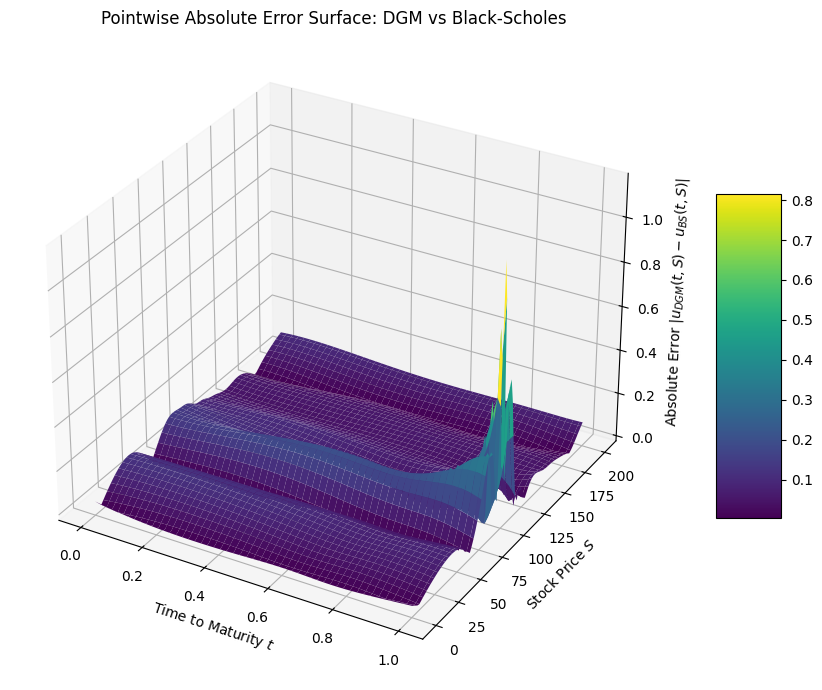

In [18]:
# Test grid
S_plot = np.linspace(0.1, 200, 100) 
t_plot = np.linspace(0, T, 100)

T_mesh, S_mesh = np.meshgrid(t_plot, S_plot)

# DGM Prediction
t_flat = torch.FloatTensor(T_mesh.reshape(-1, 1)).to(device)
S_flat = torch.FloatTensor(S_mesh.reshape(-1, 1)).to(device)

model.eval()
with torch.no_grad():
    u_pred_flat = model(t_flat, S_flat).cpu().numpy()

U_DGM = u_pred_flat.reshape(T_mesh.shape)

# Exact solution
Time_to_maturity = T - T_mesh
U_Exact = np.zeros_like(U_DGM)

for i in range(T_mesh.shape[0]):
    for j in range(T_mesh.shape[1]):
        if Time_to_maturity[i,j] <= 1e-5:
            U_Exact[i,j] = np.maximum(S_mesh[i,j] - K, 0)
        else:
            U_Exact[i,j] = black_scholes_call_price(S_mesh[i,j], K, Time_to_maturity[i,j], r, sigma)

# Absolute error
Error_surface = np.abs(U_DGM - U_Exact)

# 3D Surface Error Plot
fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(T_mesh, S_mesh, Error_surface, cmap=cm.viridis)
ax.set_xlabel('Time to Maturity $t$')
ax.set_ylabel('Stock Price $S$')
ax.set_zlabel('Absolute Error $|u_{DGM}(t, S) - u_{BS}(t, S)|$')
ax.set_title('Pointwise Absolute Error Surface: DGM vs Black-Scholes')

fig.colorbar(surf, shrink=0.5, aspect=5)
plt.tight_layout()
plt.show()

On observe un pic d'erreur autour du strike à la maturité $t=1$. Ailleurs, l'erreur est beaucoup plus faible.

Comme pour les différences finies implicites, l'erreur diminue à mesure que l'on s'éloigne de la maturité. Elle peut pourtant persister un peu plus loin dans le temps, ce qui peut être dû à la nature approximative des réseaux de neurones.

La difficulté principale reste la non-différentiabilité du payoff en $K$, qui engendre une plus grande erreur numérique près de ce point. Le réseau de neurones, qui est une fonction lisse, a du mal à capturer cette irrégularité.

La méthode Deep Galerkin capture la dynamique globale de l'EDP de Black-Scholes, mais avec une précision moindre que les méthodes numériques classiques comme les différences finies implicites, en particulier près du strike.

Questions ouvertes:
- Analyser la convergence de la méthode
- Tester la sensibilité aux paramètres
- Tester la faisabilité en grande dimension

### Analyse de la convergence

Contrairement à la méthode des différences finies, la méthode Deep Galerkin ne converge pas vers la solution exacte de l'ordre de 10^-16.

L'optimisation se fait par descente de gradient stochastique (Adam). La loss diminue rapidement au début, puis se stabilise autour d'un plateau de l'ordre de 10^-3.

Par ailleurs, les réseaux de neurones ont tendance à apprendre d'abord les composantes de basse fréquence de la solution(biais spectral), puis les détails plus fins (haute fréquence). Cela peut expliquer pourquoi l'erreur reste relativement élevée près du strike, où la solution présente une discontinuité dans la dérivée.

Pour conclure, la méthode Deep Galerkin permet d'obtenir une approximation raisonnable de la solution de l'EDP de Black-Scholes, mais avec une précision moindre que les méthodes numériques classiques. Elle est néanmoins prometteuse pour des problèmes en grande dimension où les méthodes classiques deviennent inapplicables, et plus "robuste" car moins sensible au maillage.

### Sensibilité aux paramètres

On compare trois configurations différentes:
- Standard: lr=1e-3, 50 neurones
- High LR: lr=1e-2, 50 neurones, a-t-on une convergence plus rapide mais instable ?
- Large Net: lr=1e-3, 100 neurones, plus de capacité ?

In [19]:
configs = [
    {"name": "Standard", "lr": 1e-3, "neurons": 50},
    {"name": "High LR",   "lr": 1e-2, "neurons": 50},
    {"name": "Large Net", "lr": 1e-3, "neurons": 100}
]

# Shorter training for comparison, enough to get tendencies
epochs = 2000
batch_size = 1000

In [20]:
# Compare speed
import time

In [21]:
results = {}

for config in configs:
    start_time = time.time()
    print(f"Training configuration: {config['name']}")

    temp_model = DGM(num_neurons=config['neurons']).to(device)
    temp_optimizer = optim.Adam(temp_model.parameters(), lr=config['lr'])

    losses = []
    for epoch in range(epochs):
        temp_optimizer.zero_grad()
        loss = compute_loss(temp_model, batch_size, S_min, S_max)
        loss.backward()
        temp_optimizer.step()
        losses.append(loss.item())

    end_time = time.time()
    print(f"Time taken for {config['name']}: {end_time - start_time} seconds\n")

    results[config['name']] = losses

Training configuration: Standard
Time taken for Standard: 24.557604789733887 seconds

Training configuration: High LR
Time taken for High LR: 24.259296417236328 seconds

Training configuration: Large Net
Time taken for Large Net: 36.4610321521759 seconds



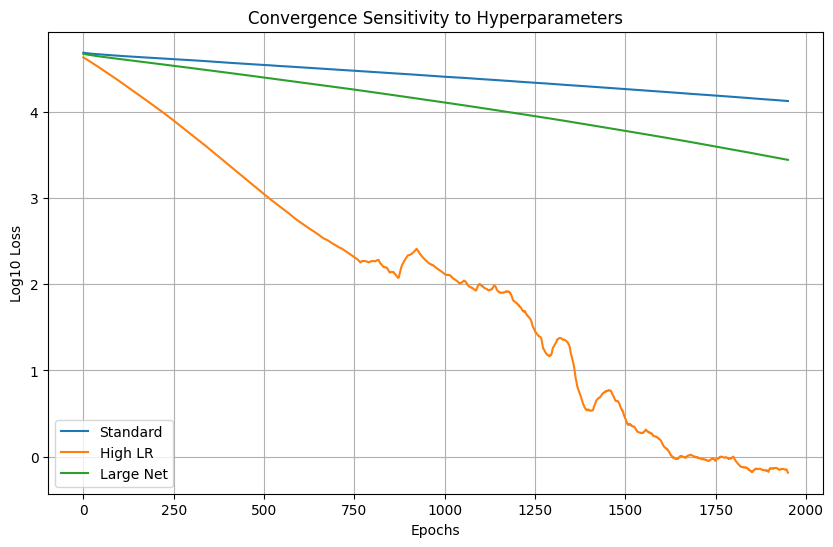

In [22]:
plt.figure(figsize=(10, 6))
for name, losses in results.items():
    smoothed = np.convolve(losses, np.ones(50)/50, mode='valid')
    plt.plot(np.log10(smoothed), label=name)

plt.title('Convergence Sensitivity to Hyperparameters')
plt.xlabel('Epochs')
plt.ylabel('Log10 Loss')
plt.legend()
plt.grid(True)
plt.show()

En comparant les courbes de perte, on observe que le modèle avec un taux d'apprentissage plus élevé (High LR) converge plus rapidement au début, mais de oscille beaucoup plus, indiquant une instabilité. 

Le modèle avec un réseau plus large (Large Net) atteint une perte finale inférieure au réseau standard, suggérant que plus de capacité permet de mieux capturer la solution. Cependant, il est beaucoup plus lent à entraîner.

### Faisabilité en grande dimension

Les méthodes de grille (différences finies) souffrent de la malédiction de la dimensionnalité, car le nombre de points de grille croît exponentiellement avec la dimension. 

En effet, pour une dimension $d$, avec $N$ points par axe, il faut calculer $N^d$ points. Pour $d=10$ et $N=100$, cela fait $100^{10} = 10^{20}$ points, ce qui est inabordable en pratique.

La méthode Deep Galerkin, en utilisant des réseaux de neurones, ne dépend pas d'une grille explicite. Le nombre de paramètres du réseau dépend principalement de son architecture (nombre de couches, neurones par couche), et non de la dimension du problème.

In [23]:
# Parameters for high-dimensional test
d = 5
S0 = 100.0
K = 100.0

In [24]:
class DGM_Multi(nn.Module):
    def __init__(self, input_dim, num_neurons=50):
        super(DGM_Multi, self).__init__()
        self.layer1 = nn.Linear(input_dim + 1, num_neurons)
        self.layer2 = nn.Linear(num_neurons, num_neurons)
        self.layer3 = nn.Linear(num_neurons, num_neurons)
        self.output = nn.Linear(num_neurons, 1)
        self.activation = nn.Tanh()

    def forward(self, t, x):
        x_norm = x / K  # Normalize S by K to improve training stability

        inputs = torch.cat([t, x_norm], dim=1)
        x = self.activation(self.layer1(inputs))
        x = self.activation(self.layer2(x))
        x = self.activation(self.layer3(x))
        u = self.output(x)
        return u
    
def compute_loss_multi(model, batch_size, dim, S_min=0.0, S_max=300.0):
    # Sampling
    t = torch.rand(batch_size, 1, device=device, requires_grad=True) * T
    S = torch.rand(batch_size, dim, device=device, requires_grad=True) * (S_max - S_min) + S_min

    u = model(t, S)

    # Gradients
    grads = torch.autograd.grad(u, [t, S], torch.ones_like(u), create_graph=True, retain_graph=True)
    u_t = grads[0]
    u_s = grads[1]

    # Second derivatives
    sum_drift = 0
    sum_diffusion = 0

    for i in range(dim):
        S_i = S[:, i:i+1]
        u_si = u_s[:, i:i+1]

        u_ss_i = torch.autograd.grad(u_si, S, torch.ones_like(u_si), create_graph=True, retain_graph=True)[0][:, i:i+1]

        sum_drift += r * S_i * u_si
        sum_diffusion += 0.5 * sigma**2 * S_i**2 * u_ss_i

    pde_residual = u_t + sum_drift + sum_diffusion - r * u
    loss_interior = torch.mean(pde_residual**2)

    # Terminal condition
    t_terminal = T * torch.ones(batch_size, 1, device=device)
    S_terminal = torch.rand(batch_size, dim, device=device) * (S_max - S_min) + S_min
    u_terminal = model(t_terminal, S_terminal)

    basket_mean = torch.mean(S_terminal, dim=1, keepdim=True)
    payoff = torch.relu(basket_mean - K)
    loss_terminal = torch.mean((u_terminal - payoff)**2)

    return loss_interior + loss_terminal

Epoch 0, Loss: 3953.842529
Epoch 500, Loss: 1832.057983
Epoch 1000, Loss: 1436.219727
Epoch 1500, Loss: 715.701477
Epoch 2000, Loss: 361.859375
Epoch 2500, Loss: 194.665237


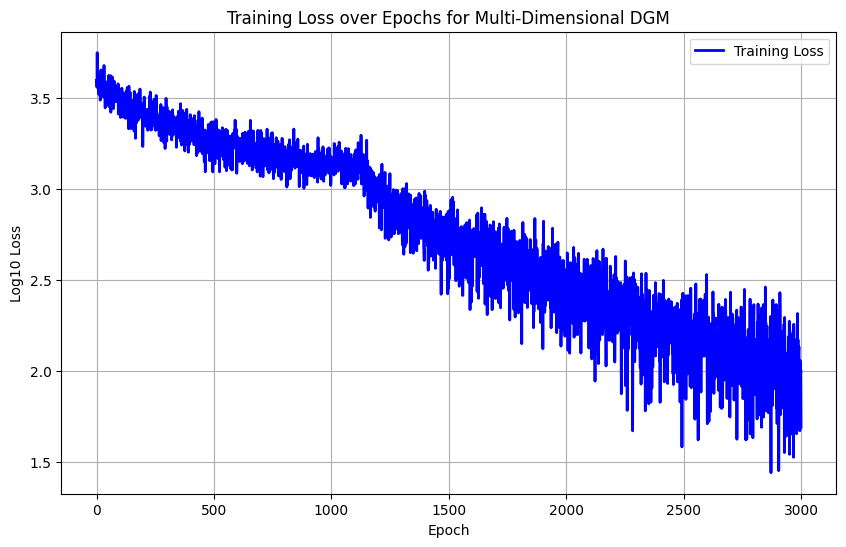

In [25]:
epochs = 3000

model_multi = DGM_Multi(input_dim=d, num_neurons=50).to(device)
optimizer_multi = optim.Adam(model_multi.parameters(), lr=1e-3)

losses_multi = []
for i in range(epochs):
    optimizer_multi.zero_grad()
    loss = compute_loss_multi(model_multi, batch_size=100, dim=d, S_min=0.0, S_max=300.0)
    loss.backward()
    optimizer_multi.step()
    losses_multi.append(loss.item())

    if i % 500 == 0:
        print(f"Epoch {i}, Loss: {loss.item():.6f}")

# Plot
plt.figure(figsize=(10, 6))
plt.plot(np.log10(losses_multi), 'b-', label='Training Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Log10 Loss')
plt.title('Training Loss over Epochs for Multi-Dimensional DGM')
plt.grid(True)
plt.legend()
plt.show()

Dimension 1, Time taken: 5.65675950050354 seconds
Dimension 5, Time taken: 12.707377910614014 seconds
Dimension 10, Time taken: 23.634464263916016 seconds
Dimension 20, Time taken: 38.31382703781128 seconds
Dimension 50, Time taken: 97.90553617477417 seconds


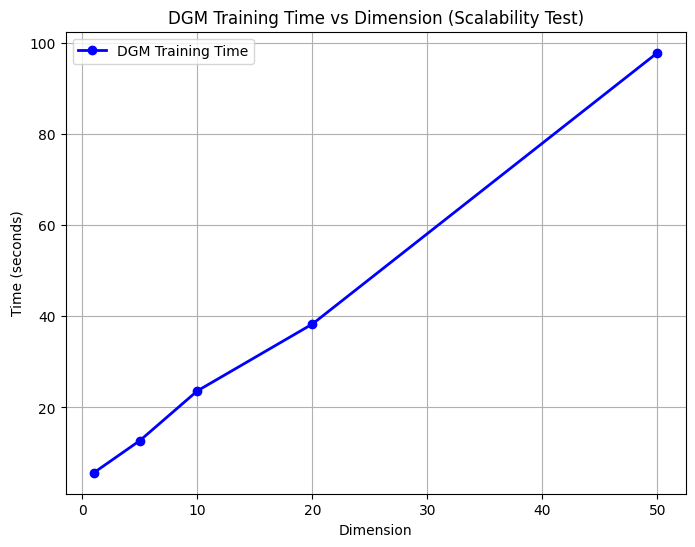

In [26]:
dims_to_test = [1, 5, 10, 20, 50]
times = []

for d in dims_to_test:
    temp_model = DGM_Multi(input_dim=d, num_neurons=50).to(device)
    temp_opt = optim.Adam(temp_model.parameters(), lr=1e-3)

    start_time = time.time()
    for epoch in range(1000):
        temp_opt.zero_grad()
        loss = compute_loss_multi(temp_model, batch_size=100, dim=d, S_min=0.0, S_max=300.0)
        loss.backward()
        temp_opt.step()

    end_time = time.time()
    times.append(end_time - start_time)
    print(f"Dimension {d}, Time taken: {end_time - start_time} seconds")

plt.figure(figsize=(8, 6))
plt.plot(dims_to_test, times, 'bo-', linewidth=2, label="DGM Training Time")
plt.title('DGM Training Time vs Dimension (Scalability Test)')
plt.xlabel('Dimension')
plt.ylabel('Time (seconds)')
plt.legend()
plt.grid(True)
plt.show()

Le graphe de la perte montre que la fonction de perte diminue progressivement, indiquant que le modèle parvient à apprendre une approximation de la solution même en dimension élevée. 

Cependant, la convergence est plus lente et l'erreur finale est plus élevée que dans le cas unidimensionnel, ce qui est attendu en raison de la complexité accrue du problème.

Cela prouve que le réseau de neurones peut s'adapter à des problèmes en grande dimension, ici en dimension 5, là où les méthodes classiques échouent par manque de mémoire (curse of dimensionality).

Le graphe de scalabilité montre que le temps d'entraînement augmente avec la dimension, mais reste gérable. On obtient une droite (croissance linéaire) en échelle logarithmique, indiquant que le temps d'entraînement croît polynomialement avec la dimension, ce qui est acceptable pour des dimensions modérées. Pour les différences finies, le temps d'entraînement croît exponentiellement, rendant la méthode inapplicable au-delà de quelques dimensions.